## Introduction
In this notebook we will create and train the classifier on the chest x-ray dataset to classify whether an image shows signs of pneumonia or not

## Imports:

* torch and torchvision for model and dataloader creation
* transforms from torchvision for Data Augmentation and Normalization
* torchmetrics for easy metric computation
* pytorch lightning for efficient and easy training implementation
* ModelCheckpoint and TensorboardLogger for checkpoint saving and logging
* tqdm for progress par when validating the model
* numpy for all kinds of stuff :)
* matplotlib for visualizing some images



In [2]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pytorch_lightning
pytorch_lightning.__version__

'2.4.0'

In [3]:
# import torch.multiprocessing as mp
# mp.set_start_method('spawn', force=True)

First we create our dataset.
We can leverage the **DatasetFolder** from torchvision: It allows to simply pass a root directory and return return a dataset object with access to all files within the directory and the directory name as class label. <br />
We only need to define a loader function, **load_file**, which defines how the files shall be loaded.
This is very comfortable as we only have to load our previously stored numpy files.
Additionally, we need to define a list of file extensions (just "npy" in our case).

Finally we can pass a transformation sequence for Data Augmentation and Normalization.

We use:
* RandomResizedCrops which applies a random crop of the image and resizes it to the original image size (224x224)
* Random Rotations between -5 and 5 degrees
* Random Translation (max 5%)
* Random Scaling (0.9-1.1 of original image size)

In [8]:
def load_file(path):
    return np.load(path).astype(np.float32)

For `Compose`, refer to https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html
<br> For `Normalize`, refer to https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html
<br> For `RandomAffine`, refer to https://pytorch.org/vision/main/generated/torchvision.transforms.RandomAffine.html


`transform` is `v2` in all the previous examples that we practiced.

In [9]:
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(0.49, 0.248),  # Use mean and std from preprocessing notebook
                                    transforms.RandomAffine( # Data Augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))

])

val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize([0.49], [0.248]),  # Use mean and std from preprocessing notebook
])



Why are not we doing `RandomAffine` for the `Validation`? ***Ans=>** RandomAffine and other augmentation techniques are excluded from the validation transforms to ensure that the validation process accurately reflects the model's ability to perform on real, unaltered data, thereby providing a clearer assessment of its generalization capabilities.*

Finally, we create the train and val dataset and the corresponding data loaders.

Please adapt batch size and num_workers according to your hardware ressources.

Refer to: https://pytorch.org/vision/main/generated/torchvision.datasets.DatasetFolder.html

torchvision.datasets.DatasetFolder(root: Union[str, Path], ***loader: Callable[[str], Any]***, extensions: Optional[Tuple[str, ...]] = None, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, is_valid_file: Optional[Callable[[str], bool]] = None, allow_empty: bool = False)

In [10]:
train_dataset = torchvision.datasets.DatasetFolder(
    "C:/Users/muaaz/Downloads/rsna_pneumonia-detection-challenge/rsna-pneumonia-detection-challenge/Processed/train/",
    loader=load_file, extensions="npy", transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    "C:/Users/muaaz/Downloads/rsna_pneumonia-detection-challenge/rsna-pneumonia-detection-challenge/Processed/val/",
    loader=load_file, extensions="npy", transform=val_transforms)


Go to the webpage and see what `torchvision.datasets.DatasetFolder` return?

In [11]:
random_index = np.random.randint(0, 20000)
my_output=train_dataset[random_index]
my_output

(tensor([[[-1.9442, -1.9442, -1.9442,  ..., -1.9586, -1.9442, -1.9442],
          [-1.9442, -1.9533, -1.9538,  ..., -1.9444, -1.9442, -1.9442],
          [-1.9442, -1.9392, -1.9389,  ..., -1.9442, -1.9442, -1.9442],
          ...,
          [-1.9284, -1.9284, -1.9284,  ..., -1.9284, -1.9284, -1.9284],
          [-1.9284, -1.9284, -1.9284,  ..., -1.9284, -1.9284, -1.9284],
          [-1.9284, -1.9284, -1.9284,  ..., -1.9284, -1.9284, -1.9284]]]),
 0)

Let's inspect some augmented train images

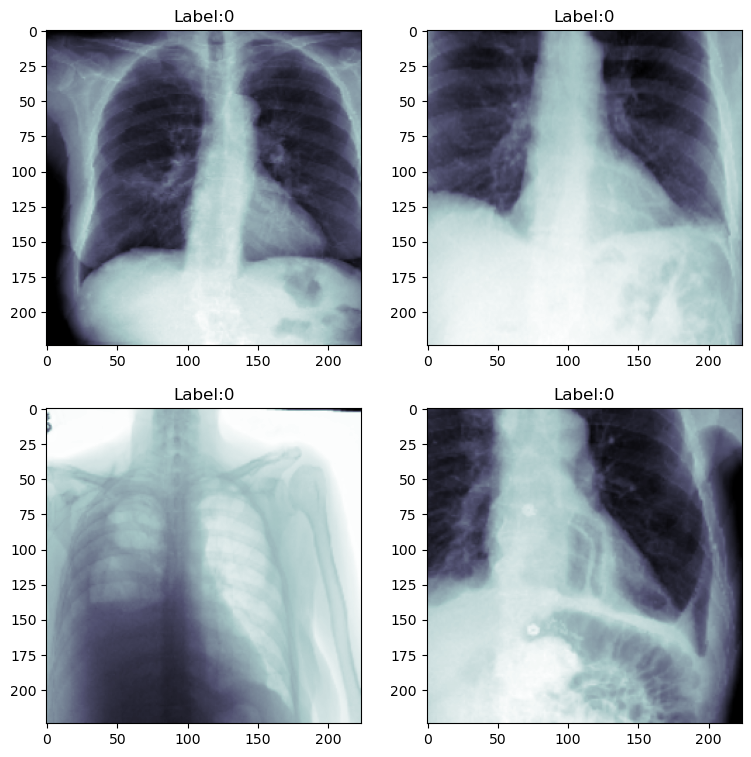

In [12]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 20000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")


Where do we get the label from `train_dataset`? How the program know what is the label. Go ro the `01-Preprocess` and you can see that we only store 2D array, right? But how did that label is inlcuded in the output?

So, we need to design a test to make sure your answer is correct. Write the code for it below. -Hint: multi-Folder idea

To test, we can also use this=> `np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)`

In [13]:
np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)

((array([0, 1]), array([18593,  5407], dtype=int64)),
 (array([0, 1]), array([2079,  605], dtype=int64)))

In [14]:
train_dataset

Dataset DatasetFolder
    Number of datapoints: 24000
    Root location: C:/Users/muaaz/Downloads/rsna_pneumonia-detection-challenge/rsna-pneumonia-detection-challenge/Processed/train/
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.49, std=0.248)
               RandomAffine(degrees=[-5.0, 5.0], translate=(0, 0.05), scale=(0.9, 1.1))
               RandomResizedCrop(size=(224, 224), scale=(0.35, 1), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
           )

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers=0, shuffle=True)
sample_batch = next(iter(train_loader))
print(f"Sample batch shape: {sample_batch[0].shape}")


In [12]:
batch_size = 64 #TODO
num_workers = 0 # TODO

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers= num_workers, shuffle=False)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 24000 train images and 2684 val images


In [13]:
# from torch.utils.data import DataLoader

# # Assuming you have training and validation datasets defined as `train_dataset` and `val_dataset`
# train_loader = DataLoader(
#     train_dataset,
#     batch_size= batch_size,  # Adjust as necessary
#     shuffle=True,    # Shuffle training data
#     num_workers= num_workers,   # Adjust based on your CPU cores
#     persistent_workers=True  # Enable persistent workers
# )

# val_loader = DataLoader(
#     val_dataset,
#     batch_size= batch_size,  # Adjust as necessary
#     shuffle=False,   # Validation data is typically not shuffled
#     num_workers= num_workers,   # Adjust based on your CPU cores
#     persistent_workers=True  # Enable persistent workers
# )

# print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

The classes are imbalanced: There are more images without signs of pneumonia than with pneumonia.
There are multiple ways to deal with imbalanced datasets:
* Weighted Loss
* Oversampling
* Doing nothing :)

In this example, we will simply do nothing as this often yields the best results.
Buf feel free to play around with a weighted loss. A template to define a customized weighted loss function is provided below.

Oversampling will be shown in a later lecture.

In [14]:
np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)

((array([0, 1]), array([18593,  5407], dtype=int64)),
 (array([0, 1]), array([2079,  605], dtype=int64)))

## Model Creation in pytorch lightning

https://lightning.ai/docs/pytorch/stable/common/lightning_module.html

=> look at the `starter example`

Each pytorch lightning model is defined by at least an initialization method, a **forward** function which defines the forward pass/prediction, a **training_step** which yields the loss and **configure_optimizers** to specify the optimization algorithm.

Additionally, we can use a **training_epoch_end** callback to compute overall dataset statistics and metrics such as accuracy.

Subsequently, we define the **validation_step**. The validation step performs more or less the same steps as the training step, however, on the validation data. In this case, pytorch lightning doesn't update the weights.
Again, we can use **validation_epoch_end** to compute overall dataset metrics.

No loops or manual weight updates are needed!<br />
Additionally, pl also handles device management.  Just pass the number of GPUS when creating the trainer.

**Now it is time to create the model** - We will use the ResNet18 network architecture.

Refer to https://www.mathworks.com/help/deeplearning/ref/resnet18.html for descriotion on ResNet18.


***Lets look at all of torchvision models: https://pytorch.org/vision/0.8/models.html*** Now, search for `resnet18` here.

As most of the torchvision models, the original ResNet expects a three channel input in **conv1**. (because of three colors)<br />

However, our X-Ray image data has only one channel.
Thus we need to change the in_channel parameter from 3 to 1.

Additionally, we will change the last fully connected layer to have only one output as we have a binary class label.

### Optimizer and Loss
We use the **Adam** Optimizer with a learning rate of 0.0001 and the **BinaryCrossEntropy** Loss function.<br />
(In fact we use **BCEWithLogitsLoss** which directly accepts the raw unprocessed predicted values and computes the sigmoid activation function before applying Cross Entropy).
Feel free to pass a weight different from 1 to the Pneumonia model in order to use the weighted loss function.


In [15]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
# class PneumoniaModel(pl.LightningModule):
#     def __init__(self, weight=1):
#         super().__init__()
        
#         self.model = torchvision.models.resnet18()
#         # change conv1 from 3 to 1 input channels
#         self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#         # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
#         self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
#         self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))
        
#         # simple accuracy computation
#         self.train_acc = torchmetrics.Accuracy(task = 'binary')
#         self.val_acc = torchmetrics.Accuracy(task = 'binary')

#     def forward(self, data):
#         pred = self.model(data)
#         return pred
    
#     def training_step(self, batch, batch_idx):
#         x_ray, label = batch
#         label = label.float()  # Convert label to float (just needed for loss computation)
#         pred = self(x_ray)[:,0]  # Prediction: Make sure prediction and label have same shape
#         loss = self.loss_fn(pred, label)  # Compute the loss
        
#         # Log loss and batch accuracy
#         self.log("Train Loss", loss)
#         self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
#         return loss

#     def train_epoch_end(self, outs):
#         # After one epoch compute the whole train_data accuracy
#         self.log("Train Acc", self.train_acc.compute())
        
#     def validation_step(self, batch, batch_idx):
#         # Same steps as in the training_step
#         x_ray, label = batch
#         label = label.float()
#         pred = self(x_ray)[:,0]  # make sure prediction and label have same shape

#         loss = self.loss_fn(pred, label)
        
#         # Log validation metrics
#         self.log("Val Loss", loss)
#         self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
#         return loss
    
#     def validation_epoch_end(self, outs):
#         self.log("Val Acc", self.val_acc.compute())
    
#     def configure_optimizers(self):
#         #Caution! You always need to return a list here (just pack your optimizer into one :))
#         return [self.optimizer]



In [4]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))
        
        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')
        
        # Track outputs for each epoch
        self.train_outputs = []
        self.val_outputs = []

    def forward(self, data):
        return self.model(data)
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)
        
        # Append predictions and labels to train_outputs
        self.train_outputs.append((pred.detach(), label.detach()))
        
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
        return loss

    def on_train_epoch_start(self):
        self.train_outputs.clear()

    def on_train_epoch_end(self):
        preds, labels = zip(*self.train_outputs)
        preds = torch.cat(preds)
        labels = torch.cat(labels)
        self.log("Train Acc", self.train_acc(torch.sigmoid(preds), labels.int()))
        self.train_outputs.clear()
        
    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)
        
        # Append predictions and labels to val_outputs
        self.val_outputs.append((pred.detach(), label.detach()))
        
        self.log("Val Loss", loss)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    def on_validation_epoch_start(self):
        self.val_outputs.clear()
        
    def on_validation_epoch_end(self):
        preds, labels = zip(*self.val_outputs)
        preds = torch.cat(preds)
        labels = torch.cat(labels)
        self.log("Val Acc", self.val_acc(torch.sigmoid(preds), labels.int()))
        self.val_outputs.clear()
    
    def configure_optimizers(self):
        return [self.optimizer]


In [5]:
model = PneumoniaModel()  # Instanciate the model

We create a checkpoint callback which only stores the 10 best models based on the validation accuracy.

In [19]:
# Create the checkpoint callback

checkpoint_callback = ModelCheckpoint(
    monitor='Val Acc',
    save_top_k=10,
    mode='max')

Trainer documentation: https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html

In [20]:
# Create the trainer
# Change the gpus parameter to the number of available gpus on your system. Use 0 for CPU training

devices = 1 #TODO
trainer = pl.Trainer(devices=devices, 
                     accelerator= 'cpu', 
                     logger=TensorBoardLogger(save_dir="./logs"), 
                     log_every_n_steps=1,
                     callbacks = checkpoint_callback,
                     max_epochs = 10)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [21]:
import ipywidgets as widgets
from IPython.display import display

In [22]:
import ipywidgets as widgets
print(widgets.__version__)

8.1.5


In [23]:
# sample_batch = next(iter(train_loader))
# print(f"Sample batch shape: {sample_batch[0].shape}")


In [24]:
trainer.fit(model, train_loader, val_loader)


  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 11.2 M | train
1 | loss_fn   | BCEWithLogitsLoss | 0      | train
2 | train_acc | BinaryAccuracy    | 0      | train
3 | val_acc   | BinaryAccuracy    | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\ProgramData\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.


## Evaluation

Let's evaluate our model!
At first, we load the latest checkpoint and send the model to the GPU, if possible.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Use strict=False, otherwise we would want to match the pos_weight which is not necessary
model = PneumoniaModel.load_from_checkpoint("C:/Users/muaaz/Downloads/rsna_pneumonia-detection-challenge/rsna-pneumonia-detection-challenge/logs/lightning_logs/version_0/checkpoints/epoch=9-step=3750.ckpt")
model.eval()
model.to(device);

Compute prediction on the complete validation set and store predictions and labels

In [15]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()


  0%|          | 0/2684 [00:00<?, ?it/s]

Compute metrics:
We can see that the overall result is already decent with our simple model.<br />
However, we suffer from a large amount of False Negatives due to the data imbalance.<br />
This is of particular importance in to avoid in medical imaging as missing findings might be fatal.<br />
Feel free to try what happens if you increase or decrease the weight in the loss.

An alternative to retraining with a weighted loss is to reduce the classification threshold from 0.5 to e.g 0.25. It produces way less false negatives but increases the number of False positives. <br />
This is called the precision-recall tradeoff

In [16]:
acc = torchmetrics.Accuracy(task="binary")(preds, labels)
precision = torchmetrics.Precision(task="binary")(preds, labels)
recall = torchmetrics.Recall(task="binary")(preds, labels)
cm = torchmetrics.ConfusionMatrix(task="binary", num_classes=2)(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(task="binary", num_classes=2, threshold=0.25)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix 2:\n {cm_threshed}")

Val Accuracy: 0.8409090638160706
Val Precision: 0.6679245233535767
Val Recall: 0.5851239562034607
Confusion Matrix:
 tensor([[1903,  176],
        [ 251,  354]])
Confusion Matrix 2:
 tensor([[1595,  484],
        [ 103,  502]])


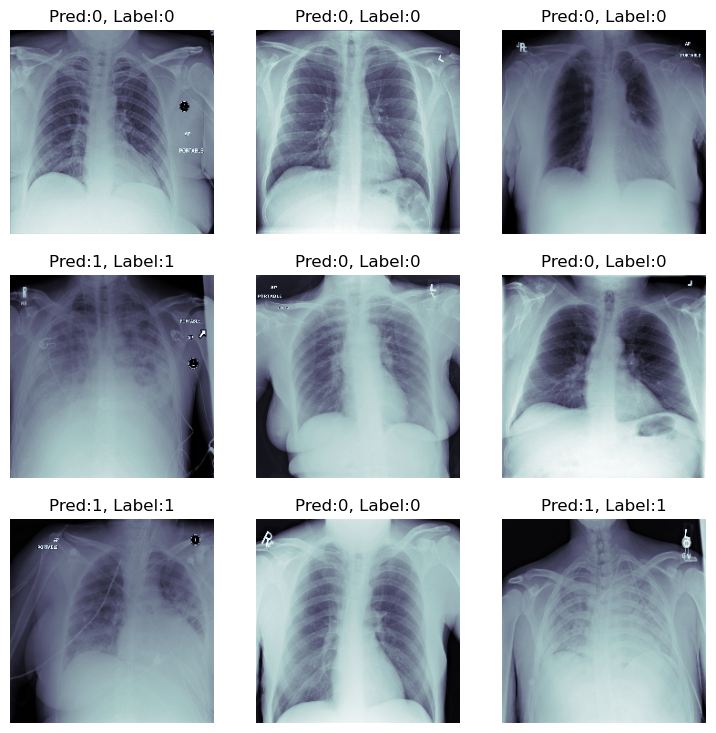

In [17]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="bone")
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")


Congratulation! You made it to the end of the notebook and to the end of the classification lecture.